In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import vonmises_fisher
import json
import os
import pandas as pd
from tqdm import tqdm
from scipy.signal import savgol_filter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FormatStrFormatter

C:\Users\jsve\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def sanity_check(matrix):
    if not np.allclose(np.linalg.norm(matrix,axis=1),1):
        raise ValueError("At least one non unit vector")
    return True

def project_and_calc_dist(X,Y,theta,delta,p):
    
    x_proj = np.dot(X, theta.T)
    y_proj = np.dot(Y, theta.T)
    qs = np.linspace(0+delta,1-delta,50)
    xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
    yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")
    dist_p = np.abs(xp_quantiles - yp_quantiles)**p
    
    return dist_p


def activation(vector):
    #input vector (L*n_projections,) --> output matrix (L,n_projections)
    #return np.exp(vector)/np.exp(vector).sum(axis=1)[:,None]
    return np.exp(vector)/np.exp(vector).sum()


def sample_theta(X,num_smaples=10):
    _ , d = X.shape
    theta = np.random.randn(num_smaples,d)
    theta_norm = np.linalg.norm(theta, axis=1)
    theta_normed = theta / theta_norm[:, np.newaxis]
    return theta_normed

def sw_vectorized(X, Y, p=1, feature_importance = False, delta = 0.0, act = False,theta=None):

    try:
        sanity_check(theta)
    except ValueError as error:
        print(error)
    
    #Calculate Wasserstein distance for each projection
    dist_p = project_and_calc_dist(X,Y,theta,delta,p)
    
    
    wd = dist_p.mean(axis=0)
    
    #weight allocation
    if act:
        #split_wd = np.array(np.split(wd,L))
        weights = activation(split_wd)
        return (wd*weights).sum(axis=0)**(1/p)
    else: 
        weights = np.ones(wd.shape[0])
        
        
    #if feature_importance:
        #ind = np.argpartition(wd,-25)[-25:]
        #return np.array(np.split(wd.T@weights,L)).mean(axis=1)**(1/p), np.mean(np.abs(theta[ind]),axis=0)
    
        return np.array(wd*weights)#np.array(wd*weights)
    
    
def load_dataset(filename,normalize=True):
    
    with open(filename, "r") as fp:
        data = json.load(fp)

    if data["time"]["index"] != list(range(0, data["n_obs"])):
        raise NotImplementedError(
            "Time series with non-consecutive time axis are not yet supported."
        )

    mat = np.zeros((data["n_obs"], data["n_dim"]))
    for j, series in enumerate(data["series"]):
        mat[:, j] = series["raw"]

    # We normalize to avoid numerical errors.
    if normalize:
        mat = (mat - np.nanmean(mat, axis=0)) / np.sqrt(np.nanvar(mat, axis=0, ddof=1))
        #mat = (mat - np.min(mat, axis=0))/(np.max(mat,axis=0)-np.min(mat,axis=0))
        
    return data, mat



In [3]:

def run(N = 20, L = 100, p=2):

    X = np.random.multivariate_normal([1,2,0.5,0.4],np.eye(4),N)

    #x1 = np.random.multivariate_normal([0,1],0.1*np.eye(2),N)
    #x2= np.random.gamma(4,1,N)
    #x3 = np.random.exponential(0.5,N)

    #X = np.hstack((x1,x2.reshape(-1,1),x3.reshape(-1,1)))
    
    #Y = X*np.random.randn(1000).reshape(-1,1)*1#np.random.multivariate_normal([1,3,0,7],np.eye(4),1000)
    Y = np.random.multivariate_normal([1,2,0.5,0.4],np.eye(4),N)
    #x1 = np.random.multivariate_normal([0,1],0.1*np.eye(2),N)
    #x2= np.random.gamma(4,1,N)
    #x3 = np.random.exponential(0.5,N)

    #Y = np.hstack((x1,x2.reshape(-1,1),x3.reshape(-1,1)))

    
    dist= []
    for k in range(5):
    
        np.random.seed(5*(k+1))
        THETA = sample_theta(X,L)

        dist.append((sw_vectorized(X,Y,theta=THETA,p=p)))
    #print(len(dist))  
    #print(np.vstack(dist))
    SWD = pd.DataFrame(np.vstack(dist)).T*np.sqrt(N)
    #print(SWD[0])
    return SWD
#sns.kdeplot(data=SWD,fill=True,alpha=.5, linewidth=0);

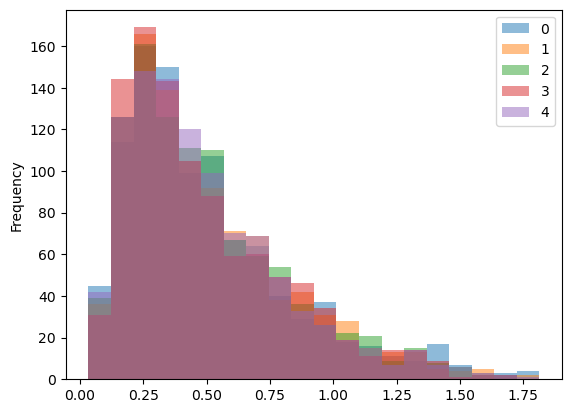

In [122]:
#MLE of alpha and beta for Γ(a,b)
df = run(N=1000,L=1000,p=2)
df.plot.hist(alpha=0.5,bins=20)

mu = df.mean(axis=0).mean()
sd = df.std(axis=0).mean()
a = mu**2/sd**2
b = sd**2/mu

b1= 1/5.41

In [124]:
b

0.2037999674809436

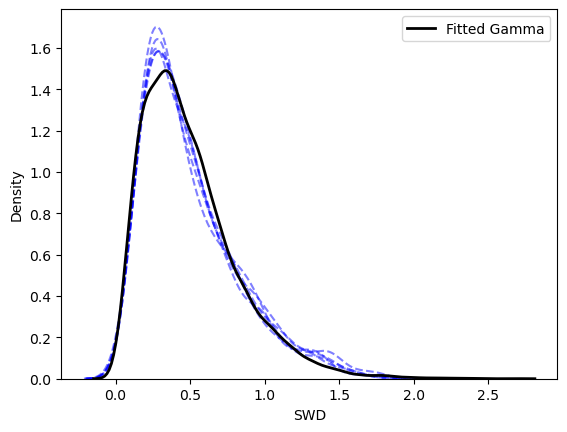

In [127]:
samples = pd.DataFrame(np.random.gamma(a,b,10000),columns=['Gamma'])
#samples_Gaussian = pd.DataFrame(np.random.normal(mu,sd**2,1000),columns=['Gaussian'])
fig, ax = plt.subplots()
#samples.plot.kde(ax=ax,color="blue")
#df.plot.kde(alpha=0.5,ax=ax,color='grey')
#samples_Gaussian.plot.kde(ax=ax,color="black")

for k in range(5):
    tmp_plot = sns.kdeplot(data=df.iloc[:,k], linewidth=1.5,ls='--',color='#0000FF',legend=False,ax=ax,alpha=0.5)
Gamma_estimate = sns.kdeplot(data=samples, x='Gamma',linewidth=2,color='black',ax=ax,label='Fitted Gamma')
ax.legend()
ax.set_xlabel('SWD');

In [96]:
d = 5

X = np.random.multivariate_normal(np.arange(0,d,1),np.eye(d),1000)
Y = np.random.multivariate_normal(np.arange(0,d,1),np.eye(d),1000)

THETA = sample_theta(X,num_smaples=1000)

SW_MC = sw_vectorized(X,Y,theta=THETA,p=2)
SW_MC_Distance = SW_MC.mean()
X_normalized = X - np.mean(X,axis=0)
Y_normalized = Y - np.mean(Y,axis=0)


m2_X = ((np.linalg.norm(X_normalized,axis=1)**2).mean() + np.linalg.norm(X.mean(axis=0))**2)/d
m2_Y = ((np.linalg.norm(Y_normalized,axis=1)**2).mean() + np.linalg.norm(Y.mean(axis=0))**2)/d

W_2 = m2_X+m2_Y -2*np.sqrt(m2_Y**0.5*m2_X*m2_Y**0.5)

SW_2_approx = W_2+ np.linalg.norm(np.mean(X,axis=0)-np.mean(Y,axis=0))**2/d
SW_2_approx**0.5

0.06944365152063339

mu1:-0.20484770711597014 
 var1:11.645153552061828
mu1:-0.04298038698624875 
 var1:1.0180617664916185


<Axes: ylabel='Density'>

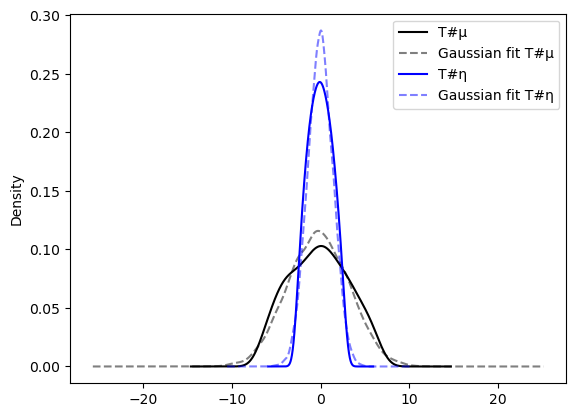

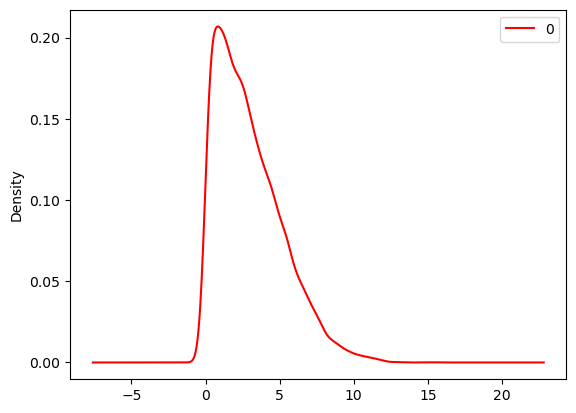

In [107]:
#### Distribution of Tθ(μ)=<μ,θ>
#Set up samples, and projection parameter
μ = np.random.multivariate_normal([2,7,0,1,0],1*np.eye(5),1000)
η = np.random.multivariate_normal([1,1,1,1,1],np.eye(5),1000)
THETA = sample_theta(μ,num_smaples=1000)

#Calculate push forwad operation T^{\theta}_{\#}
Tμ = np.dot(μ, THETA.T)
Tη = np.dot(η, THETA.T)

df_μ =pd.DataFrame(Tμ)
df_η = pd.DataFrame(Tη)




mu_1 = df_μ.mean(axis=0).mean()
sd1 = ((np.linalg.norm(μ,axis=1)**2).sum()/len(μ)/5)**0.5#((np.trace(μ@μ.T)/1000)/5)**0.5 
print('mu1:{} \n var1:{}'.format(mu_1,var1))

mu_2 = df_η.mean(axis=0).mean()
sd2 = ((np.linalg.norm(η,axis=1)**2).sum()/len(η)/5)**0.5#(pd.DataFrame(η).mean(axis=0)**2).sum()/5
print('mu1:{} \n var1:{}'.format(mu_2,var2))



Gaussian_fit_μ = np.random.normal(mu_1,sd1,size=10000)
Gaussian_fit_η = np.random.normal(mu_2,sd2,size=10000)
fig2, ax2= plt.subplots()
pd.DataFrame(np.sort(Tμ).mean(axis=0),columns=['T#μ']).plot.kde(ax=ax2,color="black")
pd.DataFrame(Gaussian_fit_μ,columns=['Gaussian fit T#μ']).plot.kde(ax=ax2,color='black',alpha=0.5,ls='--')

pd.DataFrame(np.sort(Tη).mean(axis=0),columns=['T#η']).plot.kde(ax=ax2,color="blue")
pd.DataFrame(Gaussian_fit_η,columns=['Gaussian fit T#η']).plot.kde(ax=ax2,color='blue',alpha=0.5,ls='--')


pd.DataFrame(np.abs(Gaussian_fit_μ-Gaussian_fit_η)).plot.kde(color='red')

In [74]:
var1

0.9822423038423874

In [93]:
pd.DataFrame(np.sort(Tμ).mean(axis=0)).std()

0    3.47055
dtype: float64

In [ ]:
###Richtige berechnugn

In [95]:
(np.linalg.norm(μ,axis=1)**2).sum()/len(μ)/5

11.844176641817324

In [77]:
28**0.5

5.291502622129181

In [82]:
(np.trace(μ@μ.T)/1000)/5

1.957757129277034

In [87]:
np.trace(μ@np.eye(5)@μ.T)/len(μ)/5

1.957757129277034

In [71]:
(pd.DataFrame(μ).mean(axis=0)**2).sum()/5

5.235783545098237

In [85]:
(pd.DataFrame(μ).mean(axis=0)**2).sum()/5

0.9822423038423874

In [282]:
sd = df.std(axis=0).mean()

np.linalg.norm(μ.var(axis=0))

1.7411080361402909

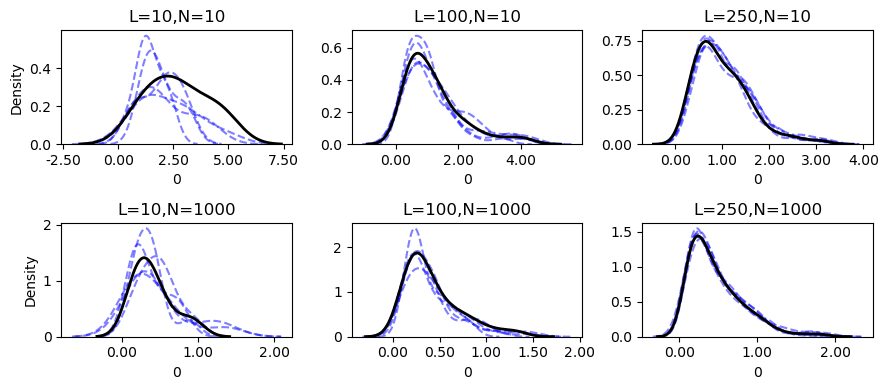

In [217]:
def get_avgKDE(snsplot,k):

    line = snsplot.lines[:]
    KDE_Vals = [line[i].get_data()[1] for i in range(k)]
    x = line[0].get_data()[0]

    y = np.vstack(KDE_Vals).T.mean(axis=1)

    
    return x,y


palette = ["#0000FF","#0000FF","#0000FF","#0000FF","#0000FF"]
#palette = ['#000000','#000000','#000000','#000000','#000000']

fig, axes = plt.subplots(nrows= 2,ncols=3,figsize=(9,4))

params = {'L':[10,25,100],'N':[20,75,100]}
i=0
for N in [10,1000]:
    j=0
    for L in [10,100,250]:
        SWD = run(L=L,N=N,p=2)
        for k in range(5):
            tmp_plot = sns.kdeplot(data=SWD.iloc[:,k], linewidth=1.5,ls='--',color='#0000FF',legend=False,ax=axes[i,j],alpha=0.5)
        x,y = get_avgKDE(tmp_plot,5)
        axes[i,j].plot(x,y,lw=2.0,color='black')
        axes[i,j].set_title("L={},N={}".format(L,N))
        #axes[i,j].yaxis.set_ticklabels([])
        axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if j>0:
            axes[i,j].set_ylabel("")
            
        j+=1
    i+=1

plt.subplots_adjust(hspace=0.5)   
plt.tight_layout()
fig.show()



In [218]:
SWD.describe()

,0,1,2,3,4
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.458215,0.489586,0.471680,0.466670,0.497658
std,0.340780,0.396170,0.326188,0.332310,0.357007
min,0.060526,0.053921,0.069600,0.059136,0.049305
25%,0.193250,0.201077,0.217066,0.200966,0.232529
50%,0.360698,0.355922,0.368396,0.358204,0.396422
75%,0.633984,0.670555,0.678273,0.656414,0.700431
max,1.863076,1.941718,1.890849,2.012944,1.766612


In [314]:
#fig.tight_layout()
#fig.show()
fig.savefig('Distance_Disrtribution_SWD.pdf')

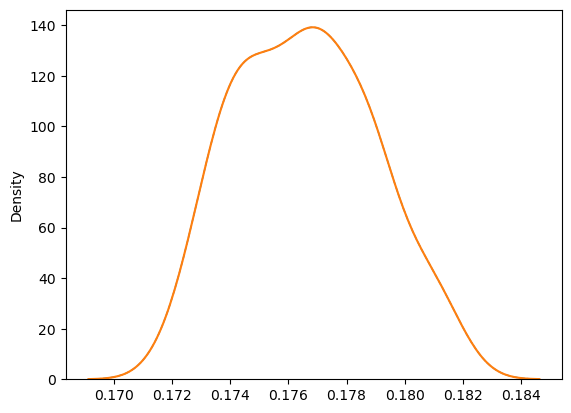

In [207]:
myplot = sns.kdeplot(data=SWD.mean(axis=1), linewidth=1,ls='--',palette="Blues",legend=False)
line = myplot.lines[0]
x, y = line.get_data()

plt.plot(x,y)

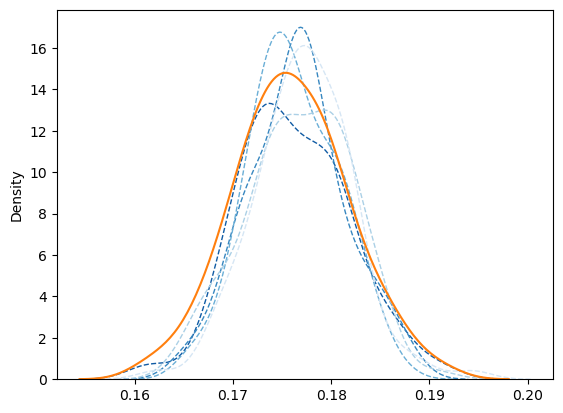

In [232]:
myplot = sns.kdeplot(data=SWD, linewidth=1,ls='--',palette="Blues",legend=False);


def get_avgKDE(snsplot,k):

    line = snsplot.lines[:]
    KDE_Vals = [line[i].get_data()[1] for i in range(k)]
    x = line[0].get_data()[0]

    y = np.vstack(KDE_Vals).T.mean(axis=1)

    
    return x,y

x,y = get_avgKDE(myplot,5)

plt.plot(x,y)

In [204]:
import scipy.stats as sps

# estimate kernel density of data
kde = sps.gaussian_kde(SWD.iloc[:,0])
kde

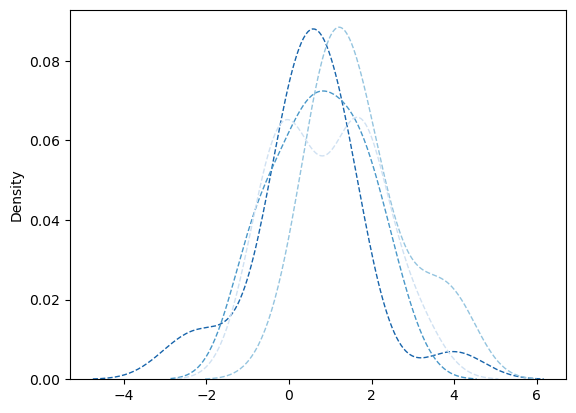

In [184]:
sns.kdeplot(data=X, linewidth=1,ls='--',palette="Blues",legend=False);